# Hit vs. Out
```python
# this works for s12-13
# dfc["threshold"] =
intercept: 0.315
(0.1, 'batter_thwackability_mul_vibe')
(-0.08, 'pitcher_unthwackability_mul_vibe')
(-0.07, 'fielder_omniscience_mul_vibe')
(0.0145, 'grand_center')
(0.0085, 'omi_center')
(-0.011, 'incon_center')
(-0.005, 'visc_center')
(0.01, 'fwd_center')

# this works for s14, though it's gross and the factors have changed, which i don't like.
# I think they accidentally had ominousness instead of obtuseness in the formula in s12-13, because
# in s14 ominousness disappears and obtuseness (which actually claims to affect hits!) shows up at
# the same power.
# dfc["threshold"] =
intercept: 0.3115
(0.1, 'batter_thwackability_mul_vibe')
(-0.08, 'pitcher_unthwackability_mul_vibe')
(-0.065, 'fielder_omniscience_mul_vibe')
(0.01, 'grand_center')
(0.0085, 'obt_center')
(-0.0033, 'omi_center')
(-0.0015, 'incon_center')
(-0.0033, 'visc_center')
(0.01, 'fwd_center')

# this works for s15 though it's really gross again which is not ideal.
# dfc["threshold"] =
intercept: 0.311
(0.1, 'batter_thwackability_mul_vibe')
(-0.08, 'pitcher_unthwackability_mul_vibe')
(-0.064, 'fielder_omniscience_mul_vibe')
(0.01, 'grand_center')
(0.008, 'obt_center')
(-0.0025, 'omi_center')
(-0.0045, 'incon_center')
(-0.0035, 'visc_center')
(0.011, 'fwd_center')
```

In [1]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [2]:
all_files = glob.glob("../roll_data/*-out.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

# seasons = [11, 12]
# seasons = [11, 12, 13, 14]
# seasons = [14]
seasons = [13]
df = df[df['season'].isin(seasons)]
len(df)

61360

In [3]:
def get_pitcher_mul(row):
    pm = str(row["pitcher_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in pm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in pm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass # sometimes traveling doesn't do anything on pitchers, but not always
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        # pass # sometimes growth doesn't do anything on pitchers, but not always
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    # if row["pitcher_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        # Did anyone with this mod *ever* pitch???
        # mul += 0.50
    return mul


def get_batter_mul(row):
    bm = str(row["batter_mods"])
    btm = str(row["batting_team_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in bm:
        mul += 0.2
    if "OVERPERFORMING" in btm:
        mul += 0.2
    if "UNDERPERFORMING" in bm:
        mul -= 0.2
    if "UNDERPERFORMING" in btm:
        mul -= 0.2
    if "TRAVELING" in btm:
        # pass
        if row["top_of_inning"]:
            mul += 0.05
    if "GROWTH" in btm:
        # pass
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "HIGH_PRESSURE" in btm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "SINKING_SHIP" in btm:
        mul += (14 - row["batting_team_roster_size"]) * 0.01
    if "AFFINITY_FOR_CROWS" in btm and row["weather"] == "Weather.BIRDS":
        mul += 0.5
    if "CHUNKY" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "SMOOTH" in bm and row["weather"] == "Weather.PEANUTS":
        # I have handling for these but it's clumsy and possibly easier to do "manually"
        pass
    if "ON_FIRE" in bm:
        # todo: handle properly, which requires figuring out how it works, which sucks
        mul += 2.0
    # if row["batter_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # this will 100% break if Dreamy gets scattered. And when they lose the old NVGs.
        # mul += 0.50
    return mul

# patch the fielder multiplier, which missed Shelled when done in resim.py (last time I ran it anyway)
def get_fielder_mul(row):
    fm = str(row["fielder_mods"])
    ptm = str(row["pitching_team_mods"])
    mul = 1
    if "OVERPERFORMING" in fm:
        mul += 0.2
    if "OVERPERFORMING" in ptm:
        mul += 0.2
    if "UNDERPERFORMING" in fm:
        mul -= 0.2
    if "UNDERPERFORMING" in ptm:
        mul -= 0.2
    if "TRAVELING" in ptm:
        # pass
        if not row["top_of_inning"]:
            mul += 0.05
    if "HIGH_PRESSURE" in ptm:
        if row["weather"] == "Weather.FLOODING" and row["baserunner_count"] > 0:
            mul += 0.25
    if "GROWTH" in ptm:
        mul += min(0.05, 0.05 * (row["day"] / 99))
    if "SINKING_SHIP" in ptm:
        mul += (14 - row["pitching_team_roster_size"]) * 0.01
    # if "AFFINITY_FOR_CROWS" in ptm and row["weather"] == "Weather.BIRDS":
        # mul += 0.5  # doesn't apply to fielders I guess?
    if "SHELLED" in fm:
        # is it this, or is it "mul = 0", I wonder
        mul -= 1.0
    # if row["fielder_name"] == "Sutton Dreamy" and row["weather"] == "Weather.ECLIPSE":
        # NVGs allow the player to play 50% better in a solar eclipse.
        # This might affect fielding and baserunning as well?
        # mul += 0.50
    return mul #if mul == 0 else 1.0

# df["batter_multiplier"] = df.apply(get_batter_mul, axis=1)
# df["pitcher_multiplier"] = df.apply(get_pitcher_mul, axis=1)
# df["fielder_multiplier"] = df.apply(get_fielder_mul, axis=1)

In [4]:
df["batter_mul"] = df.apply(get_batter_mul, axis=1)
df["pitcher_mul"] = df.apply(get_pitcher_mul, axis=1)
df["fielder_mul"] = df.apply(get_fielder_mul, axis=1)

In [5]:
df.loc[df["pitcher_mods"].astype(str).str.contains("SCATTERED"), "pitcher_vibes"] = 0
df.loc[df["batter_mods"].astype(str).str.contains("SCATTERED"), "batter_vibes"] = 0
df.loc[df["fielder_mods"].astype(str).str.contains("SCATTERED"), "fielder_vibes"] = 0

for attr in [
    "batter_buoyancy",
    "batter_divinity",
    "batter_martyrdom",
    "batter_moxie",
    "batter_musclitude",
    "batter_patheticism",
    "batter_thwackability",
    "batter_tragicness",
    "batter_coldness",
    "batter_overpowerment",
    "batter_ruthlessness",
    "batter_shakespearianism",
    "batter_suppression",
    "batter_unthwackability",
    "batter_base_thirst",
    "batter_continuation",
    "batter_ground_friction",
    "batter_indulgence",
    "batter_laserlikeness",
    "batter_anticapitalism",
    "batter_chasiness",
    "batter_omniscience",
    "batter_tenaciousness",
    "batter_watchfulness",
    "batter_pressurization",
    "batter_cinnamon",
]:
    df[attr + "_mul_vibe"] = df[attr] * df["batter_mul"] * (1 + 0.2 * df["batter_vibes"])
df = df.copy()
for attr in [
    "pitcher_buoyancy",
    "pitcher_divinity",
    "pitcher_martyrdom",
    "pitcher_moxie",
    "pitcher_musclitude",
    "pitcher_patheticism",
    "pitcher_thwackability",
    "pitcher_tragicness",
    "pitcher_ruthlessness",
    "pitcher_overpowerment",
    "pitcher_unthwackability",
    "pitcher_shakespearianism",
    "pitcher_suppression",
    "pitcher_coldness",
    "pitcher_base_thirst",
    "pitcher_continuation",
    "pitcher_ground_friction",
    "pitcher_indulgence",
    "pitcher_laserlikeness",
    "pitcher_anticapitalism",
    "pitcher_chasiness",
    "pitcher_omniscience",
    "pitcher_tenaciousness",
    "pitcher_watchfulness",
    "pitcher_pressurization",
    "pitcher_cinnamon",
]:
    df[attr + "_mul_vibe"] = df[attr] * df["pitcher_mul"] * (1 + 0.2 * df["pitcher_vibes"])

if "fielder_vibes" in df:
    for attr in [
        "fielder_anticapitalism",
        "fielder_chasiness",
        "fielder_omniscience",
        "fielder_tenaciousness",
        "fielder_watchfulness",
    ]:
        df[attr + "_mul_vibe"] = df[attr] * df["fielder_mul"] * (1 + 0.2 * df["fielder_vibes"])

df["grand_center"] = df["ballpark_grandiosity"] - 0.5
df["fort_center"]  = df["ballpark_fortification"] - 0.5
df["obt_center"]   = df["ballpark_obtuseness"] - 0.5
df["omi_center"]   = df["ballpark_ominousness"] - 0.5
df["fwd_center"]   = df["ballpark_forwardness"] - 0.5
df["visc_center"]  = df["ballpark_viscosity"] - 0.5
df["incon_center"] = df["ballpark_inconvenience"] - 0.5
df["elong_center"] = df["ballpark_elongation"] - 0.5

factor = 20
df["grand"] = df["ballpark_grandiosity"]*0.02/factor
df["fort"]  = df["ballpark_fortification"]*0.02/factor
df["obt"]   = df["ballpark_obtuseness"]*0.02/factor
df["omi"]   = df["ballpark_ominousness"]*0.02/factor
df["fwd"]   = df["ballpark_forwardness"]*0.02/factor
df["visc"]  = df["ballpark_viscosity"]*0.02/factor
df["incon"] = df["ballpark_inconvenience"]*0.02/factor
df["elong"] = df["ballpark_elongation"]*0.02/factor

# df["omni_tenac"] = df["fielder_omniscience_mul_vibe"] * df["fielder_tenaciousness_mul_vibe"]


# df["roll_minus_knowns"] = (
#     df["roll"] - 0.1 * df["batter_thwackability_mul_vibe"] + 0.08 * df["pitcher_unthwackability_mul_vibe"]
# )

# df["cold_runners"] = df["pitcher_coldness_mul_vibe"] * (1 + df["baserunner_n"])
# df["omnisq"] = df["fielder_omniscience_mul_vibe"] * df["fielder_omniscience_mul_vibe"]
# df["rollsq"] = df["roll"] * df["roll"]
df = df.copy()

In [6]:
dfc = df.copy()

dfc["grandobt"] =  dfc["grand_center"] + dfc["obt_center"]
dfc["omivisc"] = dfc["visc_center"] + dfc["omi_center"]

# for exclude_mod in ["OVERPERFORMING", "UNDERPERFORMING", "HIGH_PRESSURE", "GROWTH", "SINKING_SHIP", "TRAVELING"]:
for exclude_mod in [
    # "FLINCH", "O_NO",
    "ON_FIRE", "GROWTH", "TRAVELING"
]:
# for exclude_mod in ["SPICY", "ON_FIRE"]:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]


dfc = dfc[(dfc['pitcher_mul'] == 1) & (dfc['batter_mul'] == 1) & (dfc["fielder_mul"] == 1)]

dfc["roll_mul"] = dfc["roll"] * 35

# S12-13
# dfc["bp"] = (15*dfc["grand_center"]
#              + 9*dfc["omi_center"]
#              - 12*dfc["incon_center"]
#              - 5*dfc["visc_center"]
#              + 10*dfc["fwd_center"]
#             ) / 21

# S14
# dfc["bp"] = (+ 6*dfc["grand_center"]
#              + 4*dfc["obt_center"]
#              - 1*dfc["omi_center"]
#              - 1*dfc["incon_center"]
#              - 2*dfc["visc_center"]
#              + 5*dfc["fwd_center"]
#             )/19
# but actually I prefer this (barely, begrudingly)
dfc["bp"] = (  11* dfc["ballpark_grandiosity"]
             + 8 * dfc["ballpark_obtuseness"]
             - 2 * dfc["ballpark_ominousness"]
             - 1 * dfc["ballpark_inconvenience"]
             - 3 * dfc["ballpark_viscosity"]
             + 10* dfc["ballpark_forwardness"]
            ) / 20

# S15
# dfc["bp"] = (  18 * dfc["ballpark_grandiosity"]
#              + 18 * dfc["ballpark_obtuseness"]
#              - 5  * dfc["ballpark_ominousness"]
#              - 6  * dfc["ballpark_inconvenience"]
#              - 4  * dfc["ballpark_viscosity"]
#              + 22 * dfc["ballpark_forwardness"]
#             )/39



# dfc = dfc[dfc['stadium_id'].isna()]

print(len(dfc))
print(9/19, 'grand')
print(9/19, 'obt')
print(-2/19, 'omi')
print(-3.5/19, 'incon')
print(-2.5/19, 'visc')
print(19*0.5635079764812899, 'fwd')

43295
0.47368421052631576 grand
0.47368421052631576 obt
-0.10526315789473684 omi
-0.18421052631578946 incon
-0.13157894736842105 visc
10.706651553144509 fwd


In [7]:
# X = dfc[['roll_minus_knowns', 'passed',
X = dfc[
    [
        "roll",
        # "roll_mul",
        "passed",
        "batter_thwackability_mul_vibe",
        "pitcher_unthwackability_mul_vibe",
        # 'pitcher_coldness_mul_vibe',
        "fielder_omniscience_mul_vibe",
        # 'omnisq',
        # 'baserunner_count',
        # 'cold_runners',
        # "grand_center",
        # 'fort_center',
        # "obt_center",
        # 'omi_center',
        # 'incon_center',
        # "visc_center",
        # "fwd_center",
        # 'elong_center',
        # "grand",
        # "fort",
        # "obt",
        # "omi",
        # "incon",
        # "visc",
        # "fwd",
        # "elong",
        "bp",
    ].copy()
]
# X = X[X['roll'] < 0.85]

# X = dfc[['roll', 'pitcher_ruthlessness', 'ballpark_forwardness']]
# X = dfc[['roll', 'pitcher_ruthlessness']]
y = X["passed"]
X = X.drop("passed", axis=1)

Optimal number of features : 5
(ranking, name): (1, 'roll')
(ranking, name): (1, 'batter_thwackability_mul_vibe')
(ranking, name): (1, 'pitcher_unthwackability_mul_vibe')
(ranking, name): (1, 'fielder_omniscience_mul_vibe')
(ranking, name): (1, 'bp')


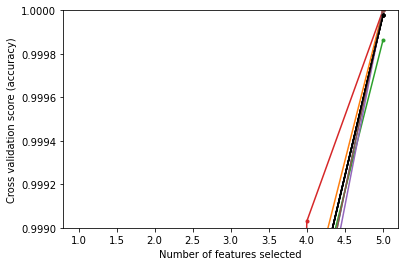

In [8]:
# pin_intercept = 0.3
# pin_intercept = None
# pins = [
#     # (0.10, 'batter_thwackability_mul_vibe'),
#     # (-0.08, 'pitcher_unthwackability_mul_vibe'),
#     # (-0.064, 'fielder_omniscience_mul_vibe'),
#     # (0.011, 'grand_center'),
#     # (0.008, 'obt_center'),
#     # (-0.003, 'omi_center'),
#     # (-0.0015, 'incon_center'),
#     # (-0.0033, 'visc_center'),
#     # (0.01, 'fwd_center')
#     # (0.034, "bp"),
# ]
# for val, var in pins:
#     X["roll"] -= X[var] * val
#     X = X.drop(var, axis=1)

# X2 = pd.DataFrame(sc.fit_transform(X), columns=X.columns)
# if pin_intercept is not None:
#     X2.iloc[:,0] -= pin_intercept / sc.scale_[0]


sc = StandardScaler(with_mean=False)
X2 = pd.DataFrame(sc.fit_transform(X), columns=X.columns)
# Create the RFE object and compute a cross-validated score.
svc = svm.LinearSVC(dual=False, max_iter=100000, C=1000000, tol=1e-8)

# The "accuracy" scoring shows the proportion of correct classifications
nfolds = 6
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=svc,
    step=1,
    cv=nfolds,#StratifiedKFold(nfolds),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
    n_jobs=-1,
)
rfecv.fit(X2, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
for n in range(nfolds):
    plt.plot(
        range(min_features_to_select, len(rfecv.cv_results_['split'+str(n)+'_test_score']) + min_features_to_select),
        rfecv.cv_results_['split'+str(n)+'_test_score'], '.-'
    )
    plt.plot(
        range(min_features_to_select, len(rfecv.cv_results_['mean_test_score']) + min_features_to_select),
        rfecv.cv_results_['mean_test_score'], 'k.-'
    )
# plt.show()
plt.ylim(0.999,1.0)
# plt.yscale("log")
# rfecv.cv_results_
for pair in zip(rfecv.ranking_, X.columns):
    print("(ranking, name):", pair)
# rfecv.support_

In [9]:
# Xr = pd.DataFrame(rfecv.transform(X), columns=rfecv.get_feature_names_out())
Xr = X.copy()
# Xr = Xr.drop("fort_center", axis=1)
# Xr = Xr.drop("elong_center", axis=1)
# Xr = Xr.drop("obt_center", axis=1)
# Xr = Xr.drop("omi_center", axis=1)

pin_intercept = None
pin_intercept = 0.300
pins = [
    (0.10, 'batter_thwackability_mul_vibe'),
    (-0.08, 'pitcher_unthwackability_mul_vibe'),
    (-0.065, 'fielder_omniscience_mul_vibe'),
    # (11, 'grand'),
    # (0, "fort"),
    # (8, 'obt'),
    # (-2, 'omi'),
    # (-1, 'incon'),
    # (-3, 'visc'),
    # (10, 'fwd'),
    # (0, 'elong'),
    (0.02, "bp"),
]
for val, var in pins:
    Xr["roll"] -= Xr[var] * val
    Xr = Xr.drop(var, axis=1)

Xr2 = pd.DataFrame(sc.fit_transform(Xr), columns=Xr.columns)
if pin_intercept is not None:
    Xr2.iloc[:,0] -= pin_intercept / sc.scale_[0]

trainedsvm = svm.LinearSVC(dual=False, max_iter=1000000, C=10000000, tol=1e-12,
                           fit_intercept=pin_intercept is None).fit(Xr2, y)
predictionsvm = trainedsvm.predict(Xr2)
# print(len(dfc[~dfc["passed"]]))
# print(len(dfc[dfc["passed"]]))
print(confusion_matrix(y, predictionsvm))
print(confusion_matrix(y, predictionsvm)[0,1] + confusion_matrix(y, predictionsvm)[1,0], "outliers")
print(trainedsvm.score(Xr2, y))

coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
intercept = trainedsvm.intercept_# - np.dot(coef, sc.mean_)
intercept_scaled = -(intercept / coef[0, 0])[0] if pin_intercept is None else pin_intercept

dfc["threshold"] = intercept_scaled
print("intercept:", intercept_scaled)
for pair in pins + list(zip(-np.array(coef_list), Xr.columns)):
    if "roll" not in pair[1]:
        print(pair)
        dfc["threshold"] += pair[0] * dfc[pair[1]]

[[30844     0]
 [    0 12451]]
0 outliers
1.0
intercept: 0.3
(0.1, 'batter_thwackability_mul_vibe')
(-0.08, 'pitcher_unthwackability_mul_vibe')
(-0.065, 'fielder_omniscience_mul_vibe')
(0.02, 'bp')


## Best formulas so far

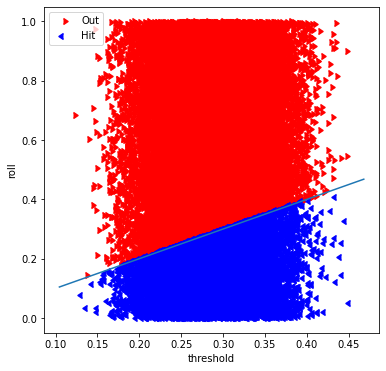

In [10]:
# this works for s12-13
# dfc["threshold"] =
# intercept: 0.315
# ( 0.1, 'batter_thwackability_mul_vibe')
# (-0.08, 'pitcher_unthwackability_mul_vibe')
# (-0.07, 'fielder_omniscience_mul_vibe')
# ( 0.5/35, 'grand_center'),
# ( 0.3/35, 'omi_center'),
# (-0.4/35, 'incon_center'),
# (-1/6/35, 'visc_center'),
# ( 1/3/35, 'fwd_center'),
# or,
# ( 0.02, "bp"),
# where
# dfc["bp"] = (15*dfc["grand_center"]
#              + 9*dfc["omi_center"]
#              - 12*dfc["incon_center"]
#              - 5*dfc["visc_center"]
#              + 10*dfc["fwd_center"]
#             ) / 21
# these coefs don't add to 21, which is weird

# this works for s14 though it's really gross and the factors have changed, which i don't like
# dfc["threshold"] =
# intercept: 0.3115
# (0.1, 'batter_thwackability_mul_vibe')
# (-0.08, 'pitcher_unthwackability_mul_vibe')
# (-0.065, 'fielder_omniscience_mul_vibe')
# (0.01, 'grand_center')
# (0.0085, 'obt_center')
# (-0.0033, 'omi_center')
# (-0.0015, 'incon_center')
# (-0.0033, 'visc_center')
# (0.01, 'fwd_center')
# or,
# ( 0.02, "bp"),
# where
# dfc["bp"] = (-3*dfc["omi_center"]
#             + 11*dfc["grand_center"]
#             + 8*dfc["obt_center"]
#             - 2*dfc["incon_center"]
#             - 4*dfc["visc_center"]
#             + 10*dfc["fwd_center"]
#            ) / 20
# those coefs actually do add to 20

# this works for s15 though it's really gross and the factors have changed, which i don't like
# dfc["threshold"] =
# intercept: 0.311
# (0.1, 'batter_thwackability_mul_vibe')
# (-0.08, 'pitcher_unthwackability_mul_vibe')
# (-0.064, 'fielder_omniscience_mul_vibe')
# (0.01, 'grand_center')
# (0.008, 'obt_center')
# (-0.0025, 'omi_center')
# (-0.0045, 'incon_center')
# (-0.0035, 'visc_center')
# (0.011, 'fwd_center')
#  .5*(.01+.008-.0025-.0045-.0035+.011) = 0.00925
y_val = "roll"
x_val = "threshold"
# x_val = "fielder_roll"
fig, ax = plt.subplots(1, figsize=(6, 6))
ax.scatter(
    dfc[~dfc["passed"]][x_val],
    dfc[~dfc["passed"]][y_val],
    color="red",
    label="Out",
    marker=CARETRIGHTBASE,
)
ax.scatter(
    dfc[dfc["passed"]][x_val],
    dfc[dfc["passed"]][y_val],
    color="blue",
    label="Hit",
    marker=CARETLEFTBASE,
)
ax.set_xlabel(x_val)
ax.set_ylabel("roll")
# ax.set_title(f"Season {season+1} Hits vs. Outs")
# ax.set_xlim(0.484, 0.499)

if x_val == "threshold":
    ax.plot(ax.get_xlim(), ax.get_xlim())

ax.legend()

In [11]:
# outliers.sort_values('roll', ascending=True).style.hide()
# dfc.groupby("fielder_name").size().sort_values(ascending=False)[0:15]

In [16]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] >= 0)) | (~dfc["passed"] & (dfc["offset"] <= 0))]


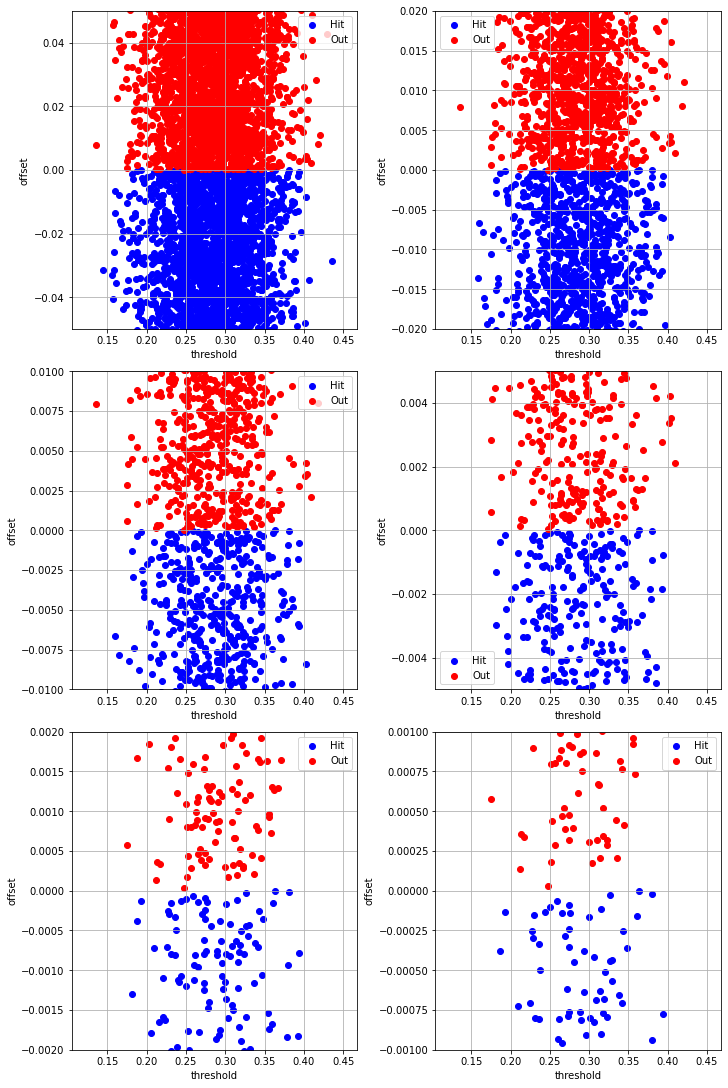

In [17]:
plt.rcParams["font.size"] = 10
x_val = "threshold"
fig, axes = plt.subplots(3, 2, figsize=(10, 15), constrained_layout=True)
# fig.suptitle(f"Season {season+1} Hits vs. Outs", fontsize=16)
dimlist = [5e-2, 2e-2, 1e-2, 0.5e-2, 0.2e-2, 0.1e-2]
for i, ax in enumerate(np.ravel(axes)):
    ax.scatter(
        dfc[dfc["passed"]][x_val],
        dfc[dfc["passed"]]["offset"],
        color="blue",
        label="Hit",
    )
    ax.scatter(
        dfc[~dfc["passed"]][x_val],
        dfc[~dfc["passed"]]["offset"],
        color="red",
        label="Out",
    )
    ax.scatter(
        outliers[~outliers["passed"]][x_val],
        outliers[~outliers["passed"]]["offset"],
        color="red",
        edgecolor="black",
    )
    ax.scatter(
        outliers[outliers["passed"]][x_val],
        outliers[outliers["passed"]]["offset"],
        color="blue",
        edgecolor="black",
    )
    ax.set_xlabel(x_val)
    ax.set_ylabel("offset")
    ax.legend()
    ax.grid()
    ax.set_ylim(-dimlist[i], dimlist[i])
# fig.savefig("../figures/hit_out_fit_offsets.png", facecolor='white')